In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import os.path as op

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse

In [2]:
def var_reject(epochs, plow, phigh, to_plot=True):
    """
    Variance based trial rejection function
    """
    badtrls = []
    trl_var, trlindx = np.empty((0,1),'float'), np.arange(0,len(epochs))
    for trnum in range(len(epochs)):
        trl_var = np.vstack((trl_var, max(np.var(np.squeeze(epochs[trnum].get_data()), axis=1))))
    lim1 = (trl_var < np.percentile(trl_var, plow, interpolation='midpoint')).flatten()
    lim2 = (trl_var > np.percentile(trl_var, phigh, interpolation='midpoint')).flatten()
    outlr_idx = trlindx[lim1].tolist() + trlindx[lim2].tolist()
    
    if to_plot:
        plt.figure(), plt.scatter(trlindx, trl_var, marker='o', s=50, c='g', label='Good trials'),
        plt.ylabel('Max. variance across channels-->')
        plt.scatter(outlr_idx, trl_var[outlr_idx], marker='o', s=50, c='r', label='Variance based bad trials'),
        plt.xlabel('Trial number-->')
        plt.scatter(badtrls, trl_var[badtrls], marker='o', s=50, c='orange', label='Manually assigned bad trials')
        plt.ylim(min(trl_var)-min(trl_var)*0.01, max(trl_var)+max(trl_var)*0.01), plt.title('Max. variance distribution')
        plt.legend()
        plt.show()
    bad_trials = np.union1d(badtrls, outlr_idx)
    print('Removed trials: %s\n'%bad_trials)
    return bad_trials

In [3]:
data_path = op.expanduser("~/data/pic-name-data-bids/")
raw_fname = op.join(data_path, 'MEG/sub-08/ses-01/meg/sub-08_ses-01_task-picturenaming_run-01_meg.fif')

In [4]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
# raw.crop(tmin=120, tmax=None)

Opening raw data file /home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08_ses-01_task-picturenaming_run-01_meg.fif...
    Range : 25000 ... 597999 =     25.000 ...   597.999 secs
Ready.
Reading 0 ... 572999  =      0.000 ...   572.999 secs...


In [ ]:
raw.plot()

In [5]:
raw.crop(tmin=60, tmax=None)

<Raw | sub-08_ses-01_task-picturenaming_run-01_meg.fif, 320 x 513000 (513.0 s), ~1.23 GB, data loaded>

In [6]:
events = mne.find_events(raw, stim_channel='STI101', min_duration=0.001, shortest_event=1)
delay = int(round(0.056 * raw.info['sfreq']))
events[:, 0] = events[:, 0] + delay

104 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  63  64  65  66  67  69  70  71  72  73  75
  77  78  79  80  82  83  84  85  86  89  90  91  92  93  94  95  96  98
  99 100 102 103 107 108 110 111 112 113 114 116 117 118]


In [8]:
event_id = None
tmin = -0.5
tmax = 1.0
picks = mne.pick_types(raw.info, meg=True, eog=True, ecg=True, stim=False, exclude='bads')
baseline = (None, 0)
# reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

In [9]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)
eog_epochs.average().plot_joint()

EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 59 significant peaks
Number of EOG events detected : 59
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
Loading data for 59 events and 1001 original time points ...
2 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


[<Figure size 800x420 with 7 Axes>, <Figure size 800x420 with 7 Axes>]

In [10]:
projs_eog, _ = mne.preprocessing.compute_proj_eog(raw, n_mag=3, n_grad=3, average=True)

Including 0 SSP projectors from raw file
Running EOG SSP computation
EOG channel index for this subject is: [306]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 59 significant peaks
Number of EOG events detected : 59
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-p

In [ ]:
# mne.viz.plot_projs_topomap(projs_eog, raw.info)

In [11]:
raw.filter(1, 20, picks=picks, filter_length='auto', n_jobs=1,
          method='fir', iir_params=None, phase='zero', fir_window='hamming',
          fir_design='firwin', skip_by_annotation=('edge', 'bad_acq_skip'),
          pad='reflect_limited', verbose=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 3301 samples (3.301 sec)



<Raw | sub-08_ses-01_task-picturenaming_run-01_meg.fif, 320 x 513000 (513.0 s), ~1.23 GB, data loaded>

In [12]:
epochs = mne.Epochs(raw, events, event_id=None, tmin=tmin, tmax=tmax,
                   baseline=baseline, picks=picks, 
                   preload=True, reject=None, flat=None, proj=False, decim=1,
                   reject_tmin=None, reject_tmax=None, detrend=None,
                   on_missing='error', reject_by_annotation=True,
                   verbose=True)

Not setting metadata
Not setting metadata
104 matching events found
Setting baseline interval to [-0.5, 0.0] sec
Applying baseline correction (mode: mean)
Loading data for 104 events and 1501 original time points ...
0 bad epochs dropped


In [13]:
epochs.pick_types(meg=True)
epochs.del_proj()
epochs.add_proj(projs_eog[::3]);
epochs.apply_proj();

2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...


In [14]:
bad_trials = var_reject(epochs, 2, 98, to_plot=False)
epochs.drop(bad_trials, reason='variance based rejection', verbose=True)

Removed trials: [ 11.  12.  19.  24.  72. 103.]

Dropped 6 epochs: 11.0, 12.0, 19.0, 24.0, 72.0, 103.0


<Epochs |  98 events (all good), -0.5 - 1 sec, baseline [-0.5, 0] sec, ~348.6 MB, data loaded,
 '1': 0
 '10': 1
 '100': 1
 '102': 1
 '103': 0
 '107': 1
 '108': 1
 '11': 1
 '110': 1
 '111': 1
 '112': 1
 '113': 1
 '114': 1
 '116': 1
 '117': 1
 '118': 1
 '12': 1
 '13': 1
 '14': 1
 '15': 1
 '16': 1
 '17': 1
 '18': 1
 '19': 1
 '2': 1
 '20': 1
 '21': 1
 '22': 1
 '23': 1
 '24': 1
 '25': 1
 '26': 1
 '27': 1
 '28': 1
 '29': 1
 '3': 1
 '30': 1
 '31': 1
 '32': 1
 '33': 1
 '34': 1
 '35': 1
 '36': 1
 '37': 1
 '38': 1
 '39': 1
 '4': 0
 '40': 1
 '41': 1
 '42': 1
 '43': 1
 '44': 1
 '45': 1
 '46': 1
 '47': 1
 '48': 1
 '49': 1
 '5': 1
 '50': 0
 '51': 1
 '52': 1
 '53': 1
 '54': 1
 '55': 1
 '56': 1
 '57': 1
 '58': 1
 '59': 1
 '6': 1
 '60': 1
 '61': 1
 '63': 1
 '64': 1
 '65': 1
 '66': 1
 '67': 1
 '69': 1
 '7': 1
 '70': 1
 '71': 1
 '72': 1
 '73': 1
 '75': 1
 '77': 1
 '78': 1
 '79': 1
 '8': 0
 '80': 1
 '82': 1
 '83': 1
 '84': 1
 '85': 1
 '86': 1
 '89': 1
 '9': 1
 '90': 1
 '91': 1
 '92': 1
 '93': 1
 '94': 1
 

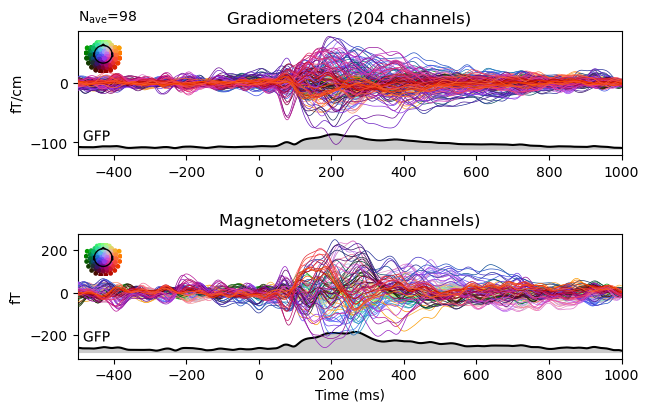

In [15]:
evoked = epochs.average()
evoked.plot(spatial_colors=True, gfp=True, proj=False, time_unit='ms')

In [ ]:
# epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
#                    baseline=baseline, reject=reject)

In [16]:
noise_cov = mne.compute_covariance(epochs, tmax=0, method=['shrunk', 'empirical'])

Computing rank from data with rank=None
    Using tolerance 1.2e-08 (2.2e-16 eps * 306 dim * 1.8e+05  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
    Created an SSP operator (subspace dimension = 2)


<ipython-input-16-cd5575a9315a>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  noise_cov = mne.compute_covariance(epochs, tmax=0, method=['shrunk', 'empirical'])


    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 304
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 49098
log-likelihood on unseen data (descending order):
   shrunk: -665.277
   empirical: -7998.116
selecting best estimator: shrunk
[done]


In [17]:
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

Computing rank from covariance with rank=None
    Using tolerance 1.4e-14 (2.2e-16 eps * 102 dim * 0.6  max singular value)
    Estimated rank (mag): 101
    MAG: rank 101 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.1e-13 (2.2e-16 eps * 204 dim * 4.7  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 204 data channels with 0 projectors


Removing projector <Projection | EOG-planar--0.200-0.200-PCA-01, active : True, n_channels : 204>


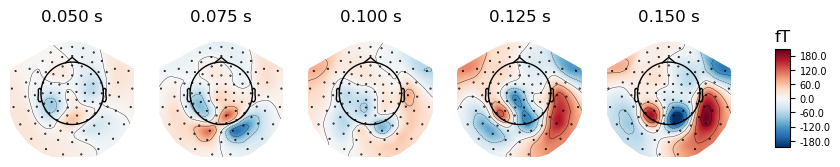

In [18]:
# evoked = epochs.average().pick_types(meg=True)
evoked.plot(time_unit='s')
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag', time_unit='s')

Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 306 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 306 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
SSS has been applied to data. Showing mag and grad whitening jointly.
    Created an SSP operator (subspace dimension = 2)
Computing rank from covariance with rank={'meg': 304}
    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 304 (2 small eigenvalues omitted)


<ipython-input-19-66b81b833363>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov, time_unit='s')
<ipython-input-19-66b81b833363>:1: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov, time_unit='s')


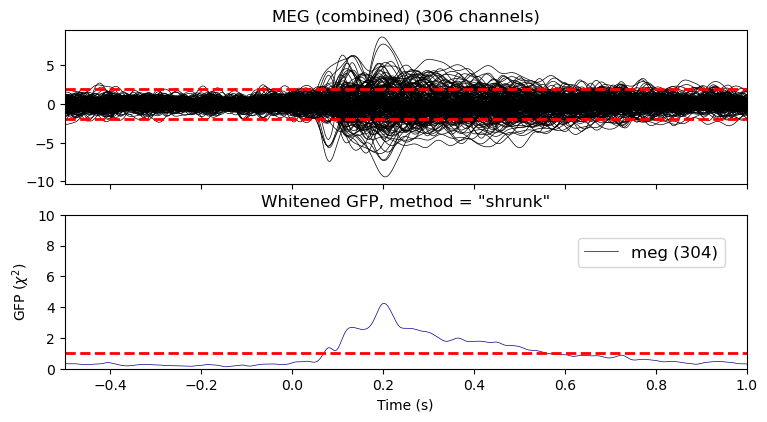

In [19]:
evoked.plot_white(noise_cov, time_unit='s')

In [20]:
del epochs, raw

In [ ]:
# src = mne.setup_source_space('sub-08', spacing='oct6', subjects_dir=subjects_dir,
#                             add_dist=False)
# model = mne.make_bem_model(subject='sub-08', ico=4, conductivity=(0.33,),
#                       subjects_dir=subjects_dir)
# bem = mne.make_bem_solution(model)

In [ ]:
# trans_fname = op.join(data_path, 'MEG/sub-08/ses-01/meg/sub-08-trans.fif')

In [ ]:
# fwd = mne.make_forward_solution(evoked.info, trans=trans_fname,
#             src=src, bem=bem, meg=True, eeg=False, mindist=5.0, n_jobs=1)

# fwd = mne.convert_forward_solution(fwd, surf_ori=True)

In [21]:
fname_fwd = op.join(data_path, 'MEG/sub-08/ses-01/meg/sub-08-cort-meg-fwd.fif')
fwd = mne.read_forward_solution(fname_fwd)

Reading forward solution from /home/anakin/data/pic-name-data-bids/MEG/sub-08/ses-01/meg/sub-08-cort-meg-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [22]:
info = evoked.info
inverse_operator = make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 3946/8196 = 10.005259
    scale = 5.02163e-07 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 2)
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 306 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
    Setting small MEG eigenvalues to zero (without PCA)


<ipython-input-22-15f95da5d27b>:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)
<ipython-input-22-15f95da5d27b>:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 71). Consider setting rank to "auto" or setting it explicitly as an integer.
  inverse_operator = make_inverse_operator(info, fwd, noise_cov, loose=0.2, depth=0.8)


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.43759
    scaling factor to adjust the trace = 7.08107e+21


In [23]:
del fwd

In [24]:
method = "dSPM"
snr = 3
lambda2 = 1 / snr ** 2
stc, residual = apply_inverse(evoked, inverse_operator, lambda2, method=method, pick_ori=None,
                             return_residual=True, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 98
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 2)
    Created the whitener using a noise covariance matrix with rank 304 (2 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.00 * 1 + 0.01 * 2 + 0.01 * 3 + 0.00 * 4 + 0.01 * 5 + 0.01 * 6 + 0.01 * 7 + 0.00 * 8 + 0.01 * 9 + 0.01 * 10 + 0.01 * 11 + 0.01 * 12 + 0.01 * 13 + 0.01 * 14 + 0.01 * 15 + 0.01 * 16 + 0.01 * 17 + 0.01 * 18 + 0.01 * 19 + 0.01 * 20 + 0.01 * 21 + 0.01 * 22 + 0.01 * 23 + 0.01 * 24 + 0.01 * 25 + 0.01 * 26 + 0.01 * 27 + 0.01 * 28 + 0.01 * 29 + 0.01 * 30 + 0.01 * 31 + 0.01 * 32 + 0.01 * 33 + 0.01 * 34 + 0.01 * 35 + 0.01 * 36 + 0.01 * 37 + 0.01 * 38 + 0.01 * 39 + 0.01 * 40 + 0.01 * 41 + 0.01 * 42 + 0.01 * 43 + 0.01 * 44 + 0.01 * 45 + 0.01 * 46 + 0.01 * 47 + 0.01 * 48 + 0.01 * 49 + 0.00 * 50 + 0.01 * 51 + 0.01 * 52

In [25]:
plt.figure()
plt.plot(1e3 * stc.times, stc.data[::100, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('%s value' % method)
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1)
evoked.plot(axes=axes)
for ax in axes:
    ax.texts = []
    for line in ax.lines:
        line.set_color('#98df81')
residual.plot(axes=axes)

In [ ]:
vertno_max, time_max = stc.get_peak(hemi='rh')
subjects_dir = op.join(data_path, 'MRI')
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[5, 7, 10]), views='lateral',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
              scale_factor=0.6, alpha=0.5)
brain.add_text(0.1, 0.9, 'dSPM (plus loc of max activ)', 'title', font_size=14)

In [ ]:
stc_vec = apply_inverse(evoked, inverse_operator, lambda2, method=method, pick_ori='vector')

In [ ]:
brain = stc_vec.plot(**surfer_kwargs)
brain.add_text(0.1, 0.9, 'Vector solution', 'title', font_size=20)

In [ ]:
del stc_vec

In [ ]:
for mi, (method, lims) in enumerate((('dSPM', [3, 4, 5]),
                                     ('sLORETA', [3, 5, 7]),
                                     ('eLORETA', [0.75, 1.25, 1.75]),)):
    surfer_kwargs['clim']['lims'] = lims
    stc = apply_inverse(evoked, inverse_operator, lambda2, method=method, pick_ori=None)
    brain = stc.plot(figure=mi, **surfer_kwargs)
    brain.add_text(0.1, 0.9, method, 'title', font_size=20)
    del stc